In [1]:
from __future__ import annotations

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm

import gymnasium as gym

from game import GameSimulator, MinimaxPlayer, RandomPlayer
from mancala_agent import MancalaAgent
import game

In [2]:
done = False
# hyperparameters
learning_rate = 0.01
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

agent = MancalaAgent(
    None,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

p1 = RandomPlayer(game.RANDOM_SEED)
game.FIRST_PLAYER_AGENT = True
env: GameSimulator = GameSimulator([agent, p1])
agent.env = env
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

In [3]:
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # Play opponent turn if agent is not the first player
    if (game.FIRST_PLAYER_AGENT and env.turn == 1) or (
        not game.FIRST_PLAYER_AGENT and env.turn == 0
    ):
        env.play_next_turn()
        obs = env.observation

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # simulate opponent turn
        env.play_next_turn()
        next_obs = env.observation

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

  0%|          | 0/10000 [00:00<?, ?it/s]/home/twitu/Code/macala-ka-diwala/.venv/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.turn to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.turn` for environment variables or `env.get_wrapper_attr('turn')` that will search the reminding wrappers.
  logger.warn(
/home/twitu/Code/macala-ka-diwala/.venv/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.play_next_turn to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.play_next_turn` for environment variables or `env.get_wrapper_attr('play_next_turn')` that will search the reminding wrappers.
  logger.warn(
/home/twitu/Code/macala-ka-diwala/.venv/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.observation to get variables from other wrappers is deprecated and will be r

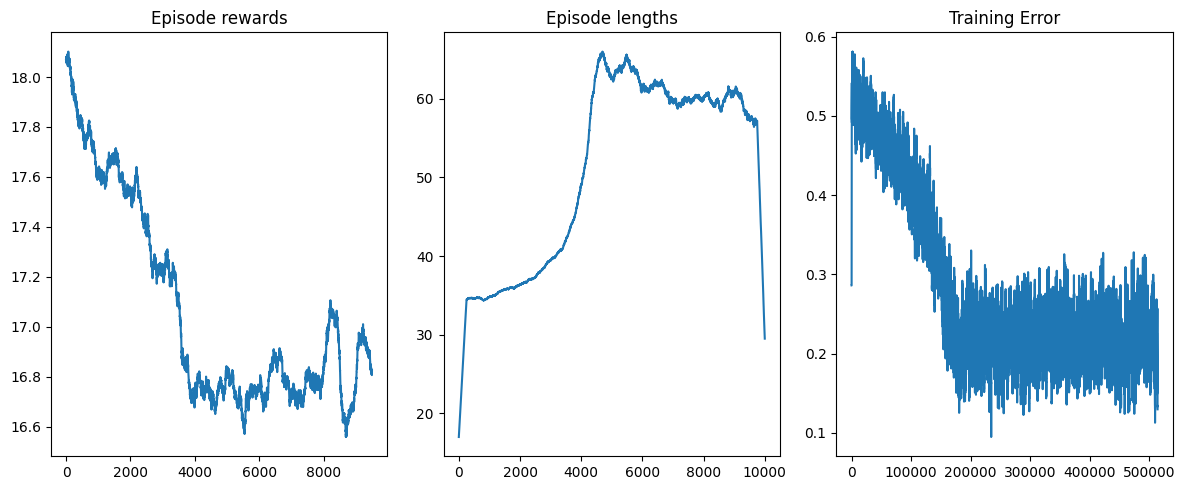

In [4]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()
